In [32]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

#Helper function

In [33]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.

    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.

    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])

    return A

#Gradient and Hessian of elastic energies

In [34]:
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the derivative of bending energy E_k^b with respect to
    x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dF : np.ndarray
        Derivative of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Gradient of bending energy
    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k

    return dF

In [35]:
def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the Hessian (second derivative) of bending energy E_k^b
    with respect to x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dJ : np.ndarray
        Hessian of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Compute the Hessian (second derivative of kappa)
    DDkappa1 = np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2

    Id3 = np.eye(3)

    # Helper matrices for second derivatives
    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)

    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
                  kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
                  (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f = np.outer(kb, m2f)

    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)
    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T

    # Populate the Hessian of kappa
    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]

    # Hessian of bending energy
    dkappa = kappa1 - kappaBar
    dJ = 1.0 / l_k * EI * np.outer(gradKappa, gradKappa)
    dJ += 1.0 / l_k * dkappa * EI * DDkappa1

    return dJ

In [36]:
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Calculate the gradient of the stretching energy with respect to the coordinates.

    Args:
    - xk (float): x coordinate of the current point
    - yk (float): y coordinate of the current point
    - xkp1 (float): x coordinate of the next point
    - ykp1 (float): y coordinate of the next point
    - l_k (float): reference length
    - EA (float): elastic modulus

    Returns:
    - F (np.array): Gradient array
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)

    F = 0.5 * EA * l_k * F  # Scale by EA and l_k

    return F

In [37]:
def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    This function returns the 4x4 Hessian of the stretching energy E_k^s with
    respect to x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    J = np.zeros((4, 4))  # Initialize the Hessian matrix
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k

    J = np.array([[J11, J12, J13, J14],
                   [J12, J22, J23, J24],
                   [J13, J23, J33, J34],
                   [J14, J24, J34, J44]])

    J *= 0.5 * EA * l_k

    return J

# Functions to create elastic force vector and its Hessian

In [38]:
def getFs(q, EA, deltaL):
  # q - DOF vector of size N
  # EA - stretching stiffness
  # deltaL - undeformed reference length (assume to be a scalar for this simple example)
  # Output:
  # Fs - a vector (negative gradient of elastic stretching force)
  # Js - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fs = np.zeros(ndof) # stretching force
  Js = np.zeros((ndof, ndof))

  for k in range(0, N-1):
      # May need to modify if network of beams
      # k-th stretching spring (USE A LOOP for the general case
      xkm1 = q[2*k] # x coordinate of the first node
      ykm1 = q[2*k+1] # y coordinate of the first node
      xk = q[2*k+2] # x coordinate of the second node
      yk = q[2*k+3] # y coordinate of the second node
      ind = np.arange(2*k, 2*k+4) # 0, 1, 2, 3 for k = 0
      gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)
      hessEnergy = hessEs(xkm1, ykm1, xk, yk, deltaL, EA)

      Fs[ind] -= gradEnergy # force = - gradient of energy. Fs is the stretching force
      Js[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:4

  return Fs, Js

In [39]:
def getFb(q, EI, deltaL):
  # q - DOF vector of size N
  # EI - bending stiffness
  # deltaL - undeformed Voronoi length (assume to be a scalar for this simple example)
  # Output:
  # Fb - a vector (negative gradient of elastic stretching force)
  # Jb - a matrix (negative hessian of elastic stretching force)

  ndof = q.size # Number of DOFs
  N = ndof // 2 # Number of nodes

  Fb = np.zeros(ndof) # bending force
  Jb = np.zeros((ndof, ndof))

  # First bending spring (USE A LOOP for the general case)
  for k in range(1, N-1):
    xkm1 = q[2*k-2] # x coordinate of the first node
    ykm1 = q[2*k-1] # y coordinate of the first node
    xk = q[2*k] # x coordinate of the second node
    yk = q[2*k+1] # y coordinate of the second node
    xkp1 = q[2*k+2] # x coordinate of the third node
    ykp1 = q[2*k+3] # y coordinate of the third node
    ind = np.arange(2*k-2, 2*k+4)
    gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)
    hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)

    Fb[ind] -= gradEnergy # force = - gradient of energy. Fb is the stretching force
    Jb[np.ix_(ind, ind)] -= hessEnergy # index vector: 0:6

  return Fb, Jb

# Objective Function or Integrator

Given the old position and the old velocity, find out th new position and the new velocity

In [40]:
def objfun(q_old, u_old, dt, tol, maximum_iter,
           m, mMat, # inertia
           EI, EA, # elastic stiffness
           W, # external force
           deltaL,
           free_index):

  q_new = q_old.copy() # Guess solution

  # Newton Raphson
  iter_count = 0 # number of iterations
  error = tol * 10 # error
  flag = 1 # if flag = 1, it is a good solution

  while error > tol:
    # Inertia
    F_inertia = m/dt * ((q_new - q_old) / dt - u_old)
    J_inertia = mMat / dt ** 2

    # Elastic forces: Stretching and Bending
    Fs, Js = getFs(q_new, EA, deltaL)
    Fb, Jb = getFb(q_new, EI, deltaL)
    F_elastic = Fs + Fb
    J_elastic = Js + Jb

    # External forces
    # Viscous force
    # Fv = - C @ ( q_new - q_old ) / dt
    # Jv = - C / dt

    # Equations of motion
    f = F_inertia - F_elastic - W # Fv
    J = J_inertia - J_elastic # - Jv

    f_free = f[free_index]
    J_free = J[np.ix_(free_index, free_index)]

    # Print norms of forces for debugging
    # print(f"Iteration {iter_count}:")
    # print(f"  Norm of F_inertia: {np.linalg.norm(F_inertia)}")
    # print(f"  Norm of F_elastic: {np.linalg.norm(F_elastic)}")
    # print(f"  Norm of Fv: {np.linalg.norm(Fv)}")
    # print(f"  Norm of W: {np.linalg.norm(W)}")
    # print(f"  Norm of residual f_free: {np.linalg.norm(f_free)}")


    # Newton's update (all DOFs are FREE)
    dq_free = np.linalg.solve(J_free, f_free)
    q_new[free_index] = q_new[free_index] - dq_free

    # Get the error
    error = np.linalg.norm(f_free)

    # Update the iteration number
    iter_count += 1
    if iter_count > maximum_iter:
      flag = -1 # Return with an error signal
      print("Maximum number of iterations reached.")
      return q_new, flag

    # u_new = (q_new - q_old) / dt # Velocity
  return q_new, flag

#Desired Path Function


In [41]:
def target_node_position(L, t):

  x_star = (L/2) * np.cos((np.pi/2)  *  (t/1000))
  y_star = - (L/2) * np.sin((np.pi/2)  *  (t/1000))

  return x_star, y_star

# PID Controller

In [42]:
# =========================
# PID Controller (reworked)
# =========================
import numpy as np

class MidNodePID:
    """
    Minimal midpoint tracker with PI on x/y.
    End-effector pose is inferred from midpoint->EE direction.
    """
    def __init__(self, Kp_x=0.1, Kp_y=0.1, Ki_x=0.1, Ki_y=0.1, deltaL=0.1):
        # gains
        self.KpX, self.KpY = Kp_x, Kp_y
        self.KiX, self.KiY = Ki_x, Ki_y

        # geometry
        self.deltaL = deltaL

        # integrators
        self.Ix = 0.0
        self.Iy = 0.0

        # command (EE pose)
        self.xc = 0.0
        self.yc = 0.0
        self.theta_c = 0.0

    def reset(self, x0, y0, th0=0.0):
        """Clear internal state and set initial EE pose."""
        self.xc, self.yc, self.theta_c = x0, y0, th0
        self.Ix, self.Iy = 0.0, 0.0

    def update(self, x_star, y_star, q, dt, N, workspace_limits=None):
        """One PI update towards the target midpoint."""
        # midpoint
        mid = (N + 1)//2 - 1
        xm, ym = q[2*mid], q[2*mid+1]

        # errors & integral
        errX, errY = (x_star - xm), (y_star - ym)
        self.Ix += errX * dt
        self.Iy += errY * dt

        # PI output (position increments for EE)
        stepX = self.KpX * errX + self.KiX * self.Ix
        stepY = self.KpY * errY + self.KiY * self.Iy
        self.xc += stepX
        self.yc += stepY

        # clip to workspace if provided
        if workspace_limits is not None:
            self.xc = np.clip(self.xc,
                              workspace_limits.get('xmin', -np.inf),
                              workspace_limits.get('xmax',  np.inf))
            self.yc = np.clip(self.yc,
                              workspace_limits.get('ymin', -np.inf),
                              workspace_limits.get('ymax',  np.inf))

        # EE heading points from mid to EE
        dx, dy = (self.xc - xm), (self.yc - ym)
        if dx*dx + dy*dy > 1e-8:
            self.theta_c = np.arctan2(dy, dx)

        # second-to-last node via geometry
        x_nm1 = self.xc - self.deltaL * np.cos(self.theta_c)
        y_nm1 = self.yc - self.deltaL * np.sin(self.theta_c)

        # keep N-1 y within workspace if needed
        if workspace_limits is not None:
            y_nm1 = np.clip(y_nm1,
                            workspace_limits.get('ymin', -np.inf),
                            workspace_limits.get('ymax',  np.inf))

        return (self.xc, self.yc, self.theta_c,
                x_nm1, y_nm1, self.xc, self.yc)


def pidController(x_star, y_star, q, dt, N, deltaL, controller_state,
                  Kp_x=0.1, Kp_y=0.1, Ki_x=0.1, Ki_y=0.1,
                  workspace_limits=None):
    """
    Stateless variant to match your existing pathPlanner signature.
    """
    # init state dictionary keys if missing
    if 'xc' not in controller_state:
        controller_state['xc'] = 0.0
    if 'yc' not in controller_state:
        controller_state['yc'] = 0.0
    if 'theta_c' not in controller_state:
        controller_state['theta_c'] = 0.0
    if 'Ix' not in controller_state:
        controller_state['Ix'] = 0.0
    if 'Iy' not in controller_state:
        controller_state['Iy'] = 0.0

    # midpoint
    mid = (N + 1)//2 - 1
    xm, ym = q[2*mid], q[2*mid+1]

    # errors & integral
    errX, errY = (x_star - xm), (y_star - ym)
    controller_state['Ix'] += errX * dt
    controller_state['Iy'] += errY * dt

    # PI increments
    stepX = Kp_x * errX + Ki_x * controller_state['Ix']
    stepY = Kp_y * errY + Ki_y * controller_state['Iy']
    controller_state['xc'] += stepX
    controller_state['yc'] += stepY

    # workspace clamp
    if workspace_limits is not None:
        controller_state['xc'] = np.clip(
            controller_state['xc'],
            workspace_limits.get('xmin', -np.inf),
            workspace_limits.get('xmax',  np.inf))
        controller_state['yc'] = np.clip(
            controller_state['yc'],
            workspace_limits.get('ymin', -np.inf),
            workspace_limits.get('ymax',  np.inf))

    # orientation from mid->EE
    dx = controller_state['xc'] - xm
    dy = controller_state['yc'] - ym
    if dx*dx + dy*dy > 1e-8:
        controller_state['theta_c'] = np.arctan2(dy, dx)

    # N-1 by geometry
    x_nm1 = controller_state['xc'] - deltaL*np.cos(controller_state['theta_c'])
    y_nm1 = controller_state['yc'] - deltaL*np.sin(controller_state['theta_c'])
    if workspace_limits is not None:
        y_nm1 = np.clip(
            y_nm1,
            workspace_limits.get('ymin', -np.inf),
            workspace_limits.get('ymax',  np.inf))

    return (controller_state['xc'], controller_state['yc'],
            controller_state['theta_c'],
            x_nm1, y_nm1,
            controller_state['xc'], controller_state['yc'])


# Main

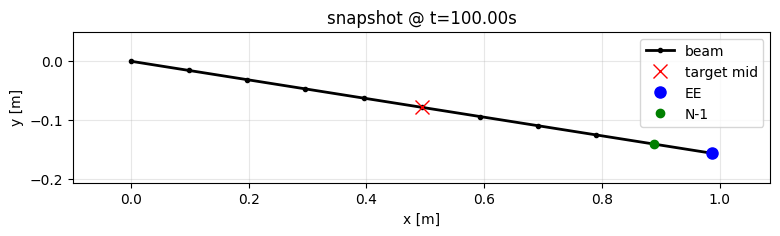

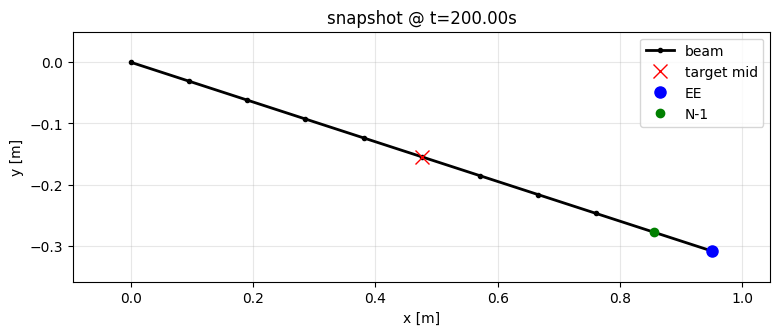

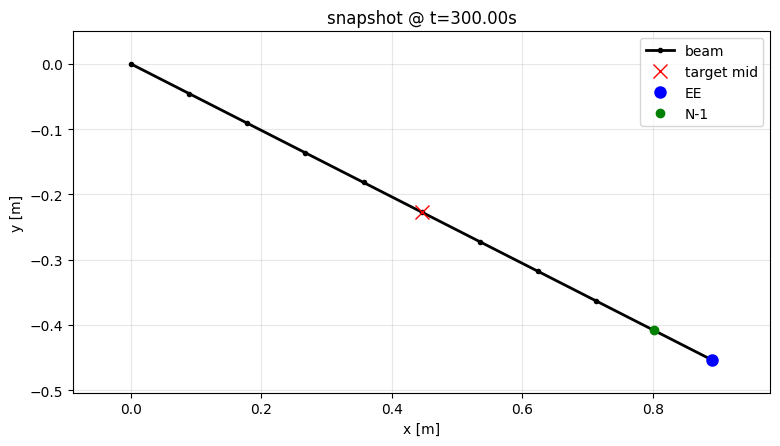

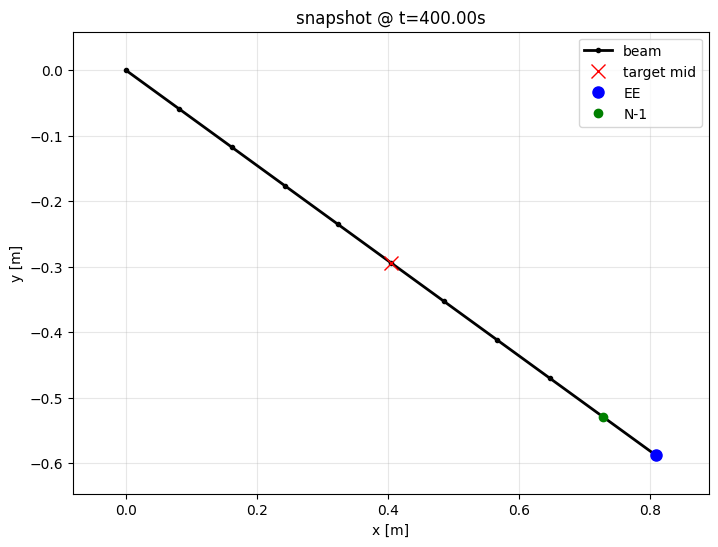

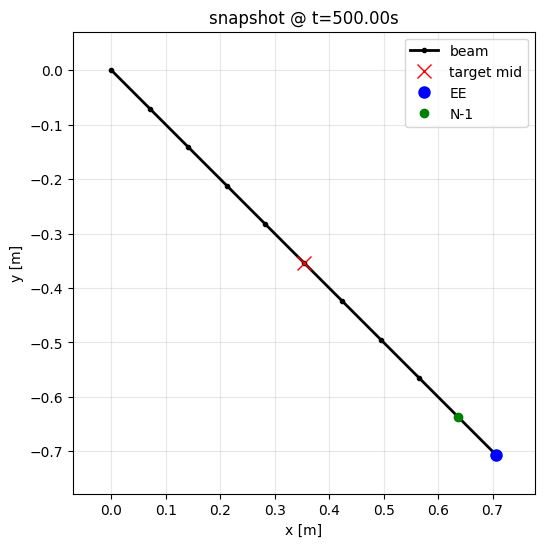

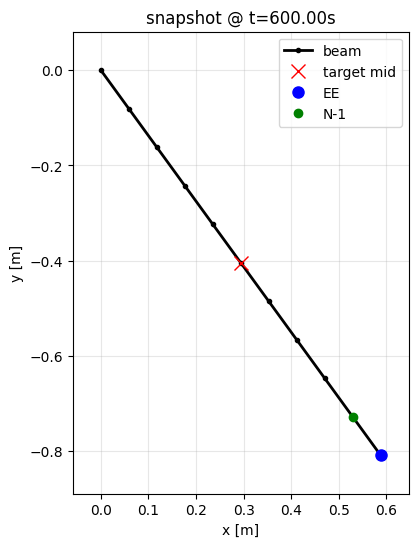

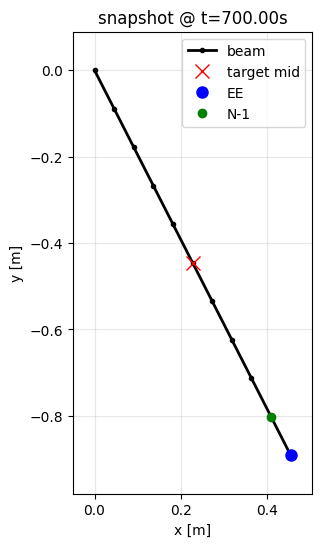

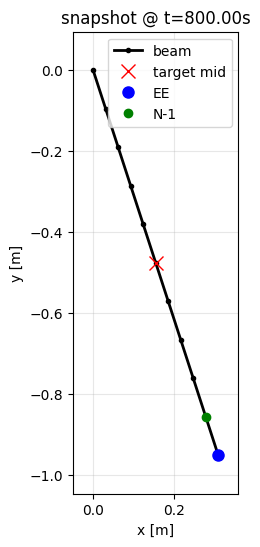

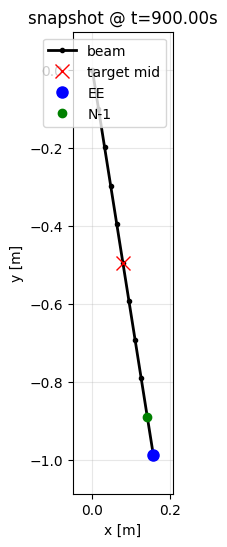

run finished.


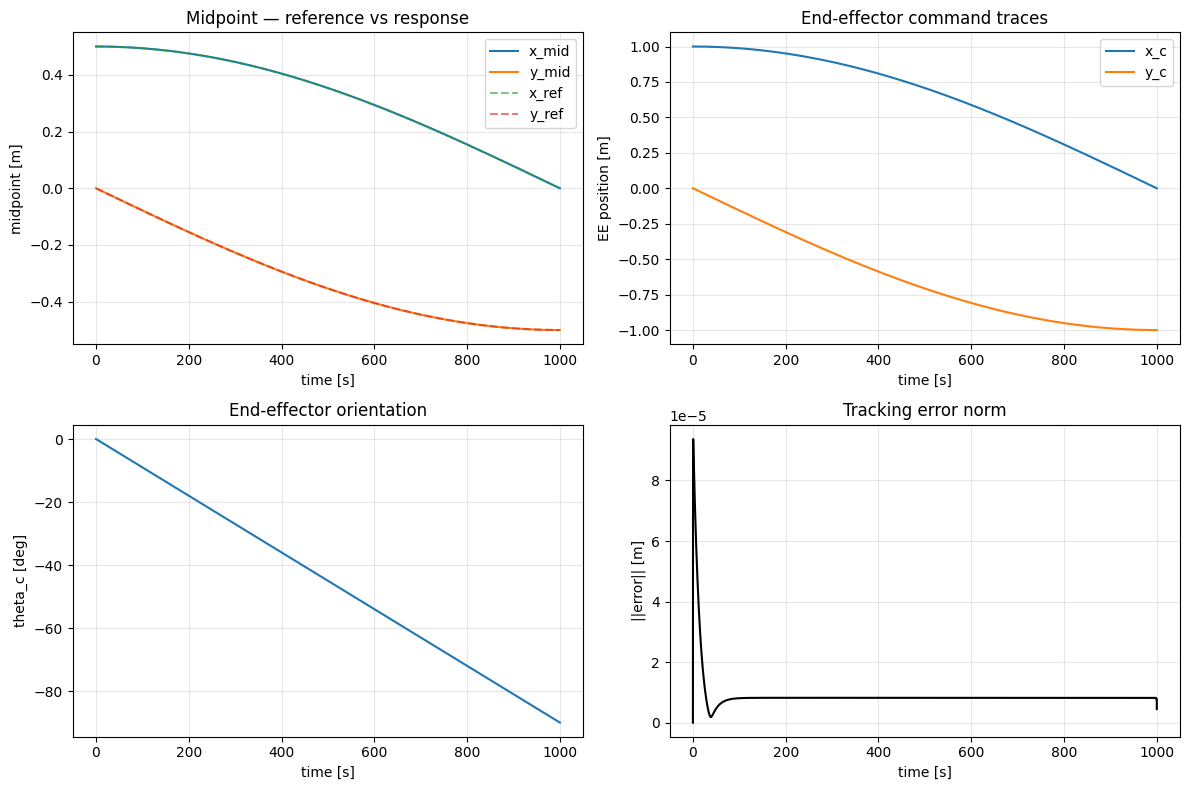

In [45]:
# =========================
# Main loop (reworked)
# =========================

nv = 11
ndof = 2 * nv
midNode = nv//2 + 1

# basic timing
dt = 0.01
totalTime = 1000
Nsteps = round(totalTime / dt)

# geometry
RodLength = 1
deltaL = RodLength / (nv - 1)

# radii / material
R_outer, R_inner = 0.013, 0.011
rho, Y = 2700, 70e9
visc = 1000.0  # unused here but kept for compatibility

maximum_iter = 80

# visualization cadence
saveImage = 0
plotStep = 10000

# beam params
I = np.pi/4 * (R_outer**4 - R_inner**4)
EI = Y * I
EA = Y * np.pi * (R_outer**2 - R_inner**2)
tol = EI / RodLength ** 2 * 1e-3

# initial straight nodes
nodes = np.zeros((nv, 2))
for c in range(nv):
    nodes[c, 0] = c * deltaL
    nodes[c, 1] = 0.0

# lumped masses
m_node = np.pi * (R_outer**2 - R_inner**2) * RodLength * rho / (nv - 1)
m = np.full(2 * nv, m_node)
mMat = np.diag(m)

# gravity load
W = np.zeros(2 * nv)
g = np.array([0, -9.8])
for k in range(nv):
    W[2*k  ] += m[2*k  ] * g[0]
    W[2*k+1] += m[2*k+1] * g[1]

# initial state
q0 = np.zeros(2 * nv)
for c in range(nv):
    q0[2*c  ] = nodes[c, 0]
    q0[2*c+1] = nodes[c, 1]
u0 = np.zeros(2 * nv)

# fixed DOFs (left clamp)
fixed_index = np.array([0, 1])

# initialize right end straight
q0[2*(nv-1)  ] = RodLength
q0[2*(nv-1)+1] = 0.0
q0[2*(nv-2)  ] = RodLength - deltaL
q0[2*(nv-2)+1] = 0.0

# mid index
midNode_index = (nv + 1)//2 - 1

# controller state dict
controller_state = {
    'xc': RodLength,
    'yc': 0.0,
    'theta_c': 0.0,
    'Ix': 0.0,
    'Iy': 0.0
}

# workspace box for EE
workspace = {'xmin': 0.0, 'xmax': RodLength,
             'ymin': -RodLength, 'ymax': 0.0}

# ---------- logs (renamed) ----------
t_series        = np.linspace(0, totalTime, Nsteps)
mid_pos_log     = np.zeros((Nsteps, 2))
mid_vel_log     = np.zeros((Nsteps, 2))
mid_seg_angle   = np.zeros(Nsteps)
ymax_log        = np.zeros(Nsteps)

ee_x_log        = np.zeros(Nsteps)
ee_y_log        = np.zeros(Nsteps)
ee_theta_log    = np.zeros(Nsteps)

xref_log        = np.zeros(Nsteps)
yref_log        = np.zeros(Nsteps)

xn1_log         = np.zeros((Nsteps, 2))
xn_log          = np.zeros((Nsteps, 2))

# seed logs
ctime = 0.0
def target_node_position(L, t):
    return (L/2.0)*np.cos((np.pi/2.0)*(t/1000.0)), -(L/2.0)*np.sin((np.pi/2.0)*(t/1000.0))

xref_log[0], yref_log[0] = target_node_position(RodLength, ctime)
mid_pos_log[0, :] = [q0[2*midNode_index], q0[2*midNode_index+1]]
mid_vel_log[0, :] = [u0[2*midNode_index], u0[2*midNode_index+1]]

vec_mid0 = np.array([q0[2*midNode_index] - q0[2*midNode_index-2],
                     q0[2*midNode_index+1] - q0[2*midNode_index-1]])
mid_seg_angle[0] = np.degrees(np.arctan2(vec_mid0[1], vec_mid0[0]))
ymax_log[0]      = np.max(q0[1::2])

ee_x_log[0], ee_y_log[0], ee_theta_log[0] = RodLength, 0.0, 0.0
xn1_log[0, :] = [RodLength - deltaL, 0.0]
xn_log[0,  :] = [RodLength, 0.0]

# ============ marching ============
for step in range(1, Nsteps):
    ctime = step * dt

    # target midpoint
    x_goal, y_goal = target_node_position(RodLength, ctime)
    xref_log[step], yref_log[step] = x_goal, y_goal

    # PI controller (stateless function variant)
    xc, yc, theta_c, xnm1, ynm1, xN, yN = pidController(
        x_goal, y_goal, q0, dt, nv, deltaL, controller_state,
        Kp_x=0.15, Kp_y=0.15, Ki_x=0.01, Ki_y=0.01,
        workspace_limits=workspace
    )

    # log commands/targets
    ee_x_log[step], ee_y_log[step], ee_theta_log[step] = xc, yc, theta_c
    xn1_log[step, :] = [xnm1, ynm1]
    xn_log[step,  :] = [xN,   yN]

    # apply BCs to guess
    q0[2*(nv-2)  ] = xnm1
    q0[2*(nv-2)+1] = ynm1
    q0[2*(nv-1)  ] = xN
    q0[2*(nv-1)+1] = yN

    # free DOFs = all minus fixed & controlled
    controlled_index = np.array([2*(nv-2), 2*(nv-2)+1, 2*(nv-1), 2*(nv-1)+1])
    all_DOFs = np.arange(ndof)
    free_index = np.setdiff1d(all_DOFs, np.concatenate((fixed_index, controlled_index)))

    # implicit solve
    q_new, flag = objfun(q0, u0, dt, tol, maximum_iter, m, mMat, EI, EA, W, deltaL, free_index)
    if flag < 0:
        print(f'Newton failed @ step {step}')
        break

    # enforce BCs on solution (drift fix)
    q_new[0], q_new[1] = 0.0, 0.0
    q_new[2*(nv-2)  ] = xnm1
    q_new[2*(nv-2)+1] = ynm1
    q_new[2*(nv-1)  ] = xN
    q_new[2*(nv-1)+1] = yN

    # velocity (backward diff)
    u_new = (q_new - q0) / dt

    # mid segment angle
    v_mid = np.array([q_new[2*midNode_index]   - q_new[2*midNode_index-2],
                      q_new[2*midNode_index+1] - q_new[2*midNode_index-1]])
    mid_seg_angle[step] = np.degrees(np.arctan2(v_mid[1], v_mid[0]))

    # logs: mid pos/vel & ymax
    mid_pos_log[step, :] = [q_new[2*midNode_index], q_new[2*midNode_index+1]]
    mid_vel_log[step, :] = [u_new[2*midNode_index], u_new[2*midNode_index+1]]
    ymax_log[step]       = np.max(q_new[1::2])

    # advance
    q0, u0 = q_new.copy(), u_new.copy()

    # optional quick-look
    if step % plotStep == 0:
        xa = q_new[::2]
        ya = q_new[1::2]

        plt.figure(1, figsize=(9,6)); plt.clf()
        plt.plot(xa, ya, 'k.-', lw=2, ms=6, label='beam')
        plt.plot(x_goal, y_goal, 'rx', ms=10, label='target mid')
        plt.plot(xc, yc, 'bo', ms=8, label='EE')
        plt.plot(xnm1, ynm1, 'go', ms=6, label='N-1')
        plt.title(f'snapshot @ t={ctime:.2f}s')
        plt.xlabel('x [m]'); plt.ylabel('y [m]')
        plt.grid(True, alpha=0.3); plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')

        xmin, xmax = xa.min(), xa.max()
        ymin, ymax = ya.min(), ya.max()
        dx = max(1e-6, xmax - xmin)
        dy = max(1e-6, ymax - ymin)
        padx = max(0.05*RodLength, 0.1*dx)
        pady = max(0.05*RodLength, 0.1*dy)
        plt.xlim(xmin - padx, xmax + padx)
        plt.ylim(ymin - pady, ymax + pady)
        plt.show()


print("run finished.")

# --------- plots (renamed titles/labels) ---------
plt.figure(2, figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t_series, mid_pos_log[:,0], label='x_mid')
plt.plot(t_series, mid_pos_log[:,1], label='y_mid')
plt.plot(t_series, xref_log, '--', alpha=0.6, label='x_ref')
plt.plot(t_series, yref_log, '--', alpha=0.6, label='y_ref')
plt.xlabel('time [s]'); plt.ylabel('midpoint [m]')
plt.title('Midpoint — reference vs response')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(t_series, ee_x_log, label='x_c')
plt.plot(t_series, ee_y_log, label='y_c')
plt.xlabel('time [s]'); plt.ylabel('EE position [m]')
plt.title('End-effector command traces')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(t_series, np.degrees(ee_theta_log))
plt.xlabel('time [s]'); plt.ylabel('theta_c [deg]')
plt.title('End-effector orientation')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
eX = xref_log - mid_pos_log[:,0]
eY = yref_log - mid_pos_log[:,1]
eN = np.sqrt(eX**2 + eY**2)
plt.plot(t_series, eN, 'k-')
plt.xlabel('time [s]'); plt.ylabel('||error|| [m]')
plt.title('Tracking error norm')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if saveImage:
    plt.savefig('fig_overview.png', dpi=180)
